# SkimLit

- NLP model to make reading medical abstracts easier
- The replicated paper (source of the dataset) is available here: https://arxiv.org/abs/1710.06071

### Confirm Access to GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-aee807c0-03c9-f7f1-c8c7-977ec6d07f8d)


## Get Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.85 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start the experiments with the 20k dataset with numbers replaced by "@" sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
import os

In [6]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data

In [7]:
# Create a function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines
    of text as list.

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [8]:
# Reading the training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

How the data could look:

```
[{
    'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines': 11
},
...
]
```

In [10]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.
    
    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sequence,
    how many sentences are in the current abstract and what sentence
    number the target line is.
    """
    input_lines = get_lines(filename) # Get all lines from filename
    abstract_lines = '' # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        # Check to see if the line is an ID line
        if line.startswith('###'):
            abstract_id = line
            # Reset the abstract string if the line is an ID line
            abstract_lines = ''
        # Check to see if line is a new line
        elif line.isspace():
            # Split abstract into separate lines
            abstract_line_split = abstract_lines.splitlines()

            # Iterate through each line in a single abstract and count them at
            # the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                # Create an empty dictionary for each line
                line_data = {}
                # Split target label from text
                target_text_split = abstract_line.split('\t')
                # Get target label
                line_data['target'] = target_text_split[0]
                # Get target text and lower it
                line_data['text'] =  target_text_split[1].lower()
                # What number line does the line appear in the abstract?
                line_data['line_number'] = abstract_line_number
                # How many total lines are there in the target abstract?
                line_data['total_lines'] = len(abstract_line_split) - 1
                # Add line data to abstract samples list
                abstract_samples.append(line_data)
        else:
            # If the above conditions aren't fulfilled, the line contains a 
            # labelled sentence
            abstract_lines += line
            
    return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 653 ms, sys: 144 ms, total: 797 ms
Wall time: 988 ms


In [12]:
# Check the first abstract of the training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
import pandas as pd

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distribution of Labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

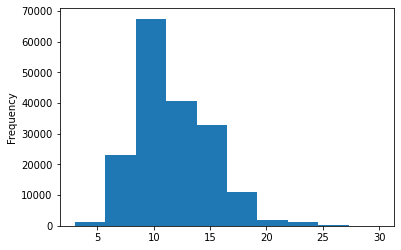

In [16]:
# Checking the length of different lines
train_df.total_lines.plot.hist()

### Get List of Sentences

In [17]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Making Numeric Labels

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
# One hot Encode Labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(
    train_df['target'].to_numpy().reshape(-1, 1)
)
val_labels_one_hot = one_hot_encoder.transform(
    val_df['target'].to_numpy().reshape(-1, 1)
)
test_labels_one_hot = one_hot_encoder.transform(
    test_df['target'].to_numpy().reshape(-1, 1)
)

train_labels_one_hot

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
train_labels_one_hot.shape

(180040, 5)

In [21]:
import tensorflow as tf

In [22]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

#### Label Encode Labels

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a Series of Modelling Experiments

### Model 0: Getting a Baseline

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [27]:
# Create a Pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [29]:
# Making predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Downloading Helper Function Script

In [30]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-06 10:13:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-06 10:13:51 (86.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [31]:
from helper_functions import calculate_results

In [32]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the Data (text) for Deep Sequence Models

In [33]:
import numpy as np
from keras import layers
import matplotlib.pyplot as plt

In [34]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [35]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

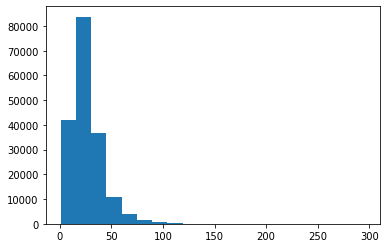

In [36]:
# What's the distribuition look like?
plt.hist(sent_lens, bins=20)

In [37]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [38]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create a Text Vectorizer Layer

In [39]:
# How many words are in the vocab? (taken from table 2 in paper)
max_tokens = 68000

In [40]:
from keras.layers import TextVectorization

In [41]:
# Create text vectorizer
text_vectorizer = TextVectorization(
    # Number of words in vocab
    max_tokens=max_tokens,
    # Desired output length of vectorized sequences
    output_sequence_length=output_seq_len
)

In [42]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [43]:
import random

In [44]:
# Test out text vectorizer on random sentences
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of Text: {len(target_sentence.split())}')
print(f'\nVectorizer Text: {text_vectorizer([target_sentence])}')

Text:
to our knowledge , a study has not been done evaluating the efficacy of injecting a low volume of ha into the adjacent area of volume loss to correct both volume loss and adjacent lines .

Length of Text: 36

Vectorizer Text: [[   6  246  494    8   17  139   31  167 1223 1556    2   79    4 7677
     8  220  326    4 3312  143    2 4976  449    4  326  264    6 2740
    54  326  264    3 4976 3598    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [45]:
# How many words in the training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [46]:
# Get the config of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Create Custom Text Embedding

In [47]:
# Create token embedding layer
token_embed = layers.Embedding(
    # Length of the vocab
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    # Using masking to handle variable sequence lengths (save space)
    mask_zero=True,
    name='token_embedding'
)

In [48]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 to our knowledge , a study has not been done evaluating the efficacy of injecting a low volume of ha into the adjacent area of volume loss to correct both volume loss and adjacent lines .

Sentence after vectorization (before embedding):
 [[   6  246  494    8   17  139   31  167 1223 1556    2   79    4 7677
     8  220  326    4 3312  143    2 4976  449    4  326  264    6 2740
    54  326  264    3 4976 3598    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02250254 -0.03712649  0.01362476 ...  0.03558804  0.0452906
    0.04454768]
  [-0.00085621  0.01568929 -0.01094347 ... -0.00047556  0.01564265
    0.02764194]
  [-0.0126045  -0.01619495  0.02494016 ... -0.01644482  0.03214128
    0.01359019]
  ...
  [-0.03658471  0.00722221 -0.00321095 ... -0.01541458 -0.02397522
    0.01824221]
  [-0.03658471  0.00722221 -0.00321095 ... -0.01541458 -0.02397522
    0.018242

## Creating Datasets

- Making sure the data loads as fast as possible

In [49]:
# Turn the data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_sentences, train_labels_one_hot
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    val_sentences, val_labels_one_hot
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    test_sentences, test_labels_one_hot
))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [50]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with Token Embeddings

In [51]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embed(text_vectors) # Create embedding
x = layers.Conv1D(
    64, kernel_size=5, padding='same', activation='relu'
)(token_embeddings)
# Condense the output of the feature vector from conv layer
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [52]:
# Get model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [53]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 50ms/step - loss: 0.9133 - accuracy: 0.6394 - val_loss: 0.6802 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.6510 - accuracy: 0.7605 - val_loss: 0.6298 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6130 - accuracy: 0.7762 - val_loss: 0.5929 - val_accuracy: 0.7866


In [54]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.72101808e-01, 1.47764057e-01, 5.82316406e-02, 2.99822748e-01,
         2.20796838e-02],
        [4.64157701e-01, 2.38784805e-01, 1.63314492e-02, 2.72186965e-01,
         8.53916537e-03],
        [1.16832145e-01, 4.81860433e-03, 1.20912318e-03, 8.77109349e-01,
         3.07120099e-05],
        ...,
        [6.11340602e-06, 5.05666249e-04, 7.47422979e-04, 5.20222329e-06,
         9.98735607e-01],
        [5.33001758e-02, 4.61135387e-01, 1.03664741e-01, 6.06581122e-02,
         3.21241587e-01],
        [1.61106825e-01, 7.21398592e-01, 3.83325554e-02, 3.58858667e-02,
         4.32761721e-02]], dtype=float32), (30212, 5))

In [55]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [56]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.62769760360122,
 'precision': 0.7836020605783443,
 'recall': 0.7862769760360122,
 'f1': 0.7837470754950409}

## Model 2: Feature Extraction with Pretrained Token Embeddings

- https://tfhub.dev/google/universal-sentence-encoder/4

In [57]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable=False,
    name='universal_sentence_encoder'
)

In [58]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random Sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence After Embedding:\n {use_embedded_sentence[0][:30]}\n')
print(f'Length of Sentence Embedding: {len(use_embedded_sentence[0])}')

Random Sentence:
 they were randomly selected and replaced through the single-stage cluster sampling .
Sentence After Embedding:
 [-0.00903649 -0.01568086  0.01085705  0.03341111 -0.05355044 -0.05472898
  0.07675857  0.0399605  -0.09989204 -0.04262371  0.03985026  0.01165132
  0.04269453  0.06756485 -0.01067976  0.04782983  0.04125875 -0.03476913
  0.01916914  0.0468927  -0.05321902  0.06335095 -0.05910463  0.04944942
 -0.04500638  0.03455292  0.006854    0.07631272  0.01124961 -0.06159259]

Length of Sentence Embedding: 512


## Building and Fitting an NLP Feature Extraction Model using Pretrained Embeddings TensorFlow Hub

In [59]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
# Tokenize text and create embedding of each sequence (512 long vector)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [60]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [61]:
# Fit model_2
history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 16ms/step - loss: 0.9162 - accuracy: 0.6519 - val_loss: 0.7970 - val_accuracy: 0.6858
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7699 - accuracy: 0.7001 - val_loss: 0.7549 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7539 - accuracy: 0.7102 - val_loss: 0.7395 - val_accuracy: 0.7118


In [62]:
# Evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7421 - accuracy: 0.7122


[0.7420981526374817, 0.7122335433959961]

In [63]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[4.3238482e-01, 3.6327088e-01, 2.1074328e-03, 1.9489333e-01,
        7.3435274e-03],
       [3.3025178e-01, 4.9609375e-01, 4.1816155e-03, 1.6673119e-01,
        2.7417024e-03],
       [2.2884801e-01, 1.4923635e-01, 2.0892441e-02, 5.6231809e-01,
        3.8705155e-02],
       ...,
       [1.9506960e-03, 5.5160713e-03, 5.1693611e-02, 7.9958927e-04,
        9.4004005e-01],
       [4.1874200e-03, 4.2028349e-02, 2.0383756e-01, 1.1967197e-03,
        7.4874997e-01],
       [1.8412445e-01, 2.5416386e-01, 4.8686495e-01, 6.3329940e-03,
        6.8513721e-02]], dtype=float32)

In [64]:
# Convert the predictions probabilities found with 
# feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [65]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.22335495829472,
 'precision': 0.7126331337314536,
 'recall': 0.7122335495829472,
 'f1': 0.7094424843292759}

## Model 3: Conv1D with Character Embeddings

### Creating a Character-level Tokenizer

In [66]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [67]:
# Making function to split sentences into characters
def split_chars(text):
    return ' '.join(list(text))

In [68]:
# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e y   w e r e   r a n d o m l y   s e l e c t e d   a n d   r e p l a c e d   t h r o u g h   t h e   s i n g l e - s t a g e   c l u s t e r   s a m p l i n g   .'

In [69]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [70]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

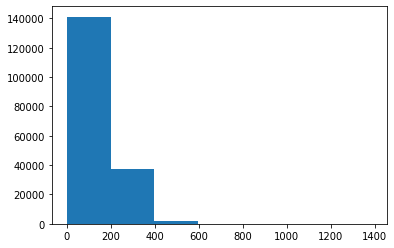

In [71]:
# Check the distribution of the sequence at a character-level
plt.hist(char_lens, bins=7)

In [72]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [73]:
import string

In [74]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
# Create char-level token vectorizer instance
# add 2 for space and OOV tokens (out of vocab)
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_mode='int',
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')

In [76]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [77]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of Different Characters in Character Vocab: {len(char_vocab)}')
print(f'5 Most common characters: {char_vocab[:5]}')
print(f'5 Least common characters: {char_vocab[-5:]}')

Number of Different Characters in Character Vocab: 28
5 Most common characters: ['', '[UNK]', 'e', 't', 'i']
5 Least common characters: ['k', 'x', 'z', 'q', 'j']


In [78]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 w e   i n t e n d   t o   r e c r u i t   @   n u r s i n g   h o m e   r e s i d e n t s   a n d   @   p e e r   v o l u n t e e r s   f r o m   t h e   i n s t i t u t e   o f   a c t i v e   a g e i n g   i n   h o n g   k o n g   i n   a   g r o u p   t r i a l   f o r   a n   @ - w e e k   g r o u p - b a s e d   i n t e g r a t e d   p a i n   m a n a g e m e n t   p r o g r a m   .

Length of random_train_chars: 163

Vectorized chars:
 [[20  2  4  6  3  2  6 10  3  7  8  2 11  8 16  4  3  6 16  8  9  4  6 18
  13  7 15  2  8  2  9  4 10  2  6  3  9  5  6 10 14  2  2  8 21  7 12 16
   6  3  2  2  8  9 17  8  7 15  3 13  2  4  6  9  3  4  3 16  3  2  7 17
   5 11  3  4 21  2  5 18  2  4  6 18  4  6 13  7  6 18 23  7  6 18  4  6
   5 18  8  7 16 14  3  8  4  5 12 17  7  8  5  6 20  2  2 23 18  8  7 16
  14 22  5  9  2 10  4  6  3  2 18  8  5  3  2 10 14  5  4  6 15  5  6  5
  18  2 15  2  6  3 14  8  7 18  8  5 15  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  

## Creating a Character-level Embedding

In [79]:
# Create a char embedding layer
char_embed = layers.Embedding(
    # Number of different characters
    input_dim=len(char_vocab),
    output_dim=25,
    mask_zero=True,
    name='char_embed'
)

In [80]:
# Test out the character embedding layer
print(f'Charified Text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (After vectorization and embedding):\n {char_embed_example}')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified Text:
 w e   i n t e n d   t o   r e c r u i t   @   n u r s i n g   h o m e   r e s i d e n t s   a n d   @   p e e r   v o l u n t e e r s   f r o m   t h e   i n s t i t u t e   o f   a c t i v e   a g e i n g   i n   h o n g   k o n g   i n   a   g r o u p   t r i a l   f o r   a n   @ - w e e k   g r o u p - b a s e d   i n t e g r a t e d   p a i n   m a n a g e m e n t   p r o g r a m   .

Embedded chars (After vectorization and embedding):
 [[[-0.04733501  0.00653584  0.01064169 ...  0.03042429  0.01074351
   -0.02057129]
  [-0.01230692  0.03247864 -0.03362396 ...  0.03077983 -0.04752028
   -0.01079671]
  [-0.0485246  -0.0360016   0.02801828 ... -0.01252224  0.04647155
   -0.03535862]
  ...
  [-0.0495326   0.03470573 -0.00696163 ... -0.01980423  0.02700073
   -0.03454251]
  [-0.0495326   0.03470573 -0.00696163 ... -0.01980423  0.02700073
   -0.03454251]
  [-0.0495326   0.03470573 -0.00696163 ... -0.01980423  0.02700073
   -0.03454251]]]
Character embedding shape: (1, 

Shape (1, 290, 25):
1 sequence, 290 characters (padded), each of the characters is a 25 long vector

### Building a Conv1D Model to Fit on Character Embedding

In [81]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [82]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [83]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices(
    (train_chars, train_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices(
    (val_chars, val_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices(
    (test_chars, test_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [84]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2628 - accuracy: 0.5010 - val_loss: 1.0328 - val_accuracy: 0.6041
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9946 - accuracy: 0.6039 - val_loss: 0.9251 - val_accuracy: 0.6373
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.9177 - accuracy: 0.6403 - val_loss: 0.8499 - val_accuracy: 0.6722


In [85]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.17489216, 0.41346183, 0.08903266, 0.26726082, 0.05535251],
       [0.46441093, 0.2351115 , 0.01587565, 0.26508707, 0.01951482],
       [0.17748381, 0.27423474, 0.09735049, 0.3930863 , 0.05784462],
       ...,
       [0.04271292, 0.06977922, 0.11600569, 0.05338538, 0.71811676],
       [0.02407299, 0.06479223, 0.59111404, 0.01733495, 0.30268586],
       [0.33244592, 0.5041427 , 0.0925496 , 0.05012074, 0.02074104]],
      dtype=float32)

In [86]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 2, 1])>

In [87]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.90096650337614,
 'precision': 0.6516086018469588,
 'recall': 0.6590096650337615,
 'f1': 0.6478406399525639}

## Model 4: Combining Pretrained Token Embeddings and Characters Embeddings (Hybrid Embedding)

1. Create a token-level embedding model
2. Create a character-level embedding model
3. Combine 1 & 2 with layers.Concatenate.

In [88]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs
token_char_concat = layers.Concatenate(name='token_char_hybrid')(
    [token_model.output, char_model.output]
)

# 4. Create output layers - Adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
layers.Dense(num_classes)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [89]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [90]:
from keras.utils import plot_model

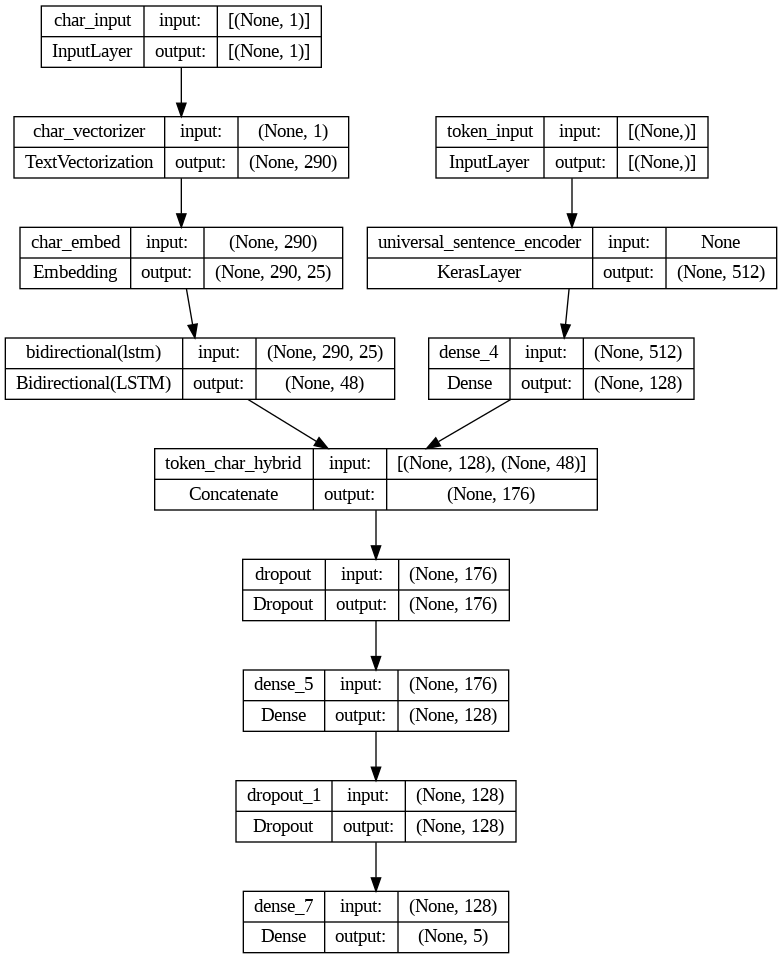

In [91]:
# Plot hybrid token and character model
plot_model(model_4, show_shapes=True)

In [92]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining Token and Character Data into a tf.data.Dataset

In [93]:
# Combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars)
)

train_token_char_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot
)

train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,
                                                train_token_char_labels))

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE
)

In [94]:
# Repeat the above steps for the validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars)
)

val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_token_char_dataset = tf.data.Dataset.zip(
    (val_token_char_data, val_token_char_labels)
)

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE
)

In [95]:
# Check out the training char and token embedding dataset
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a Model on Token and Character-level Sequences

In [96]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_token_char_dataset,
                        steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                        epochs=3,
                        validation_data=val_token_char_dataset,
                        validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 49s 63ms/step - loss: 0.9801 - accuracy: 0.6056 - val_loss: 0.7854 - val_accuracy: 0.7035
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.8028 - accuracy: 0.6895 - val_loss: 0.7193 - val_accuracy: 0.7247
Epoch 3/3
562/562 [==============================] - 29s 51ms/step - loss: 0.7784 - accuracy: 0.7037 - val_loss: 0.6907 - val_accuracy: 0.7387


In [97]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6964 - accuracy: 0.7337


[0.6963845491409302, 0.733748197555542]

In [98]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 18ms/step


array([[4.3849730e-01, 3.8621449e-01, 4.2295596e-03, 1.6520229e-01,
        5.8561983e-03],
       [3.1830186e-01, 5.1711327e-01, 3.1639058e-03, 1.5936397e-01,
        2.0570129e-03],
       [2.4595952e-01, 6.0435854e-02, 3.2221038e-02, 6.4274055e-01,
        1.8643055e-02],
       ...,
       [4.5109668e-04, 7.1396474e-03, 4.5398235e-02, 2.0754732e-04,
        9.4680351e-01],
       [9.0143029e-03, 7.8796797e-02, 2.1119584e-01, 5.0080367e-03,
        6.9598502e-01],
       [3.3394608e-01, 3.7623331e-01, 2.0149593e-01, 3.5448525e-02,
        5.2876174e-02]], dtype=float32)

In [99]:
# Convert prediction probabilities to class labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [100]:
# Calculate results for Conv1D model chars only
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.37481795313121,
 'precision': 0.7343033931966331,
 'recall': 0.7337481795313121,
 'f1': 0.7307182432127015}

## Model 5: Transfer Learning with Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

In [101]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


- **Engineered features need to be available at test time**
- Are the features available?
    - line_number ✅
    - total_lines ✅

### Create Positional Embeddings

In [102]:
# How many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

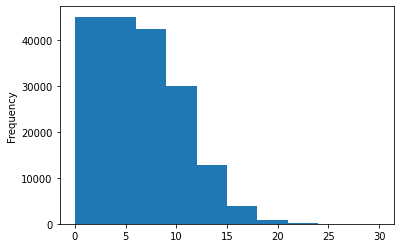

In [103]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [105]:
# Using TensorFlow to create one-hot-encoded tensors of the 
# "line_number" column
train_line_numbers_one_hot = tf.one_hot(
    train_df['line_number'].to_numpy(),
    depth=15
)
val_line_numbers_one_hot = tf.one_hot(
    val_df['line_number'].to_numpy(),
    depth=15
)
test_line_numbers_one_hot = tf.one_hot(
    test_df['line_number'].to_numpy(),
    depth=15
)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [106]:
# How many different number of lines are there
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

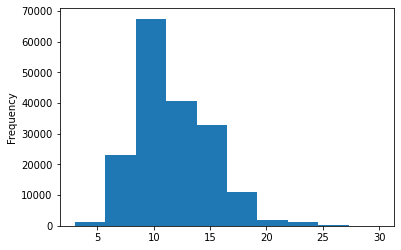

In [107]:
# Plotting the distribution of total_lines
train_df.total_lines.plot.hist()

In [109]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [111]:
# Use tensorflow to create one-hot-encoded tensors to the
# "total_lines" feature
train_total_lines_one_hot = tf.one_hot(
    train_df['total_lines'].to_numpy(),
    depth=20
)
val_total_lines_one_hot = tf.one_hot(
    val_df['total_lines'].to_numpy(),
    depth=20
)
test_total_lines_one_hot = tf.one_hot(
    test_df['total_lines'].to_numpy(),
    depth=20
)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a Tribrid Embedding Model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an outputs layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [115]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, 
                                  name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
# Combine inputs and dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, 
                                  name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(
    name='char_token_hybrid_embedding'
)([token_model.output, char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embedding
tribrid_embeddings = layers.Concatenate(
    name='char_token_positional_embedding'
)([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', 
                            name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='tribrid_embedding_model')

In [116]:
# Get a summary of the tribrid embedding model
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

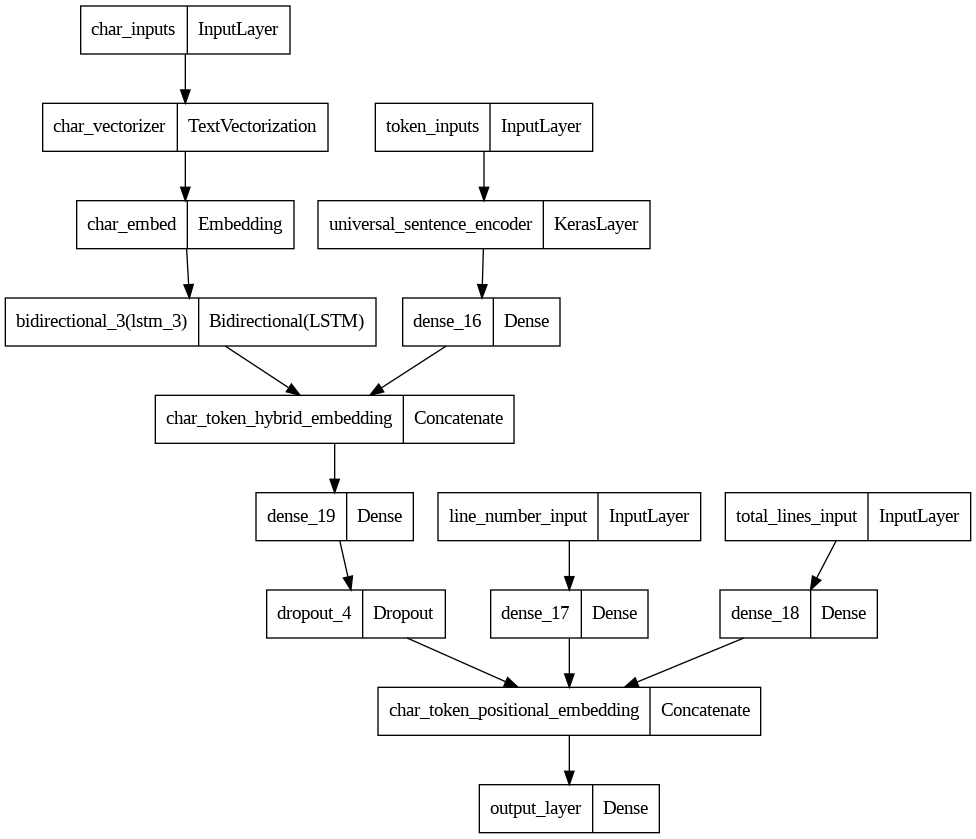

In [117]:
# Plot model_5
plot_model(model_5)

In [118]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.2), # Helps to prevent overfitting
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

### Create Tribrid Embedding Datasets using tf.data

In [121]:
# Create training and validation datasets with all four kinds of input data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices(
    (train_line_numbers_one_hot,
     train_total_lines_one_hot,
     train_sentences,
     train_chars)
)
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot
)
train_char_token_pos_dataset = tf.data.Dataset.zip(
    (train_char_token_pos_data, train_char_token_pos_labels)
)
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE)

# Do the same as above for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices(
    (val_line_numbers_one_hot,
     val_total_lines_one_hot,
     val_sentences,
     val_chars)
)
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(
    val_labels_one_hot
)
val_char_token_pos_dataset = tf.data.Dataset.zip(
    (val_char_token_pos_data, val_char_token_pos_labels)
)
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE)

In [122]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, Evaluating and Making Predictions with the Tribrid Model

In [123]:
# Fit the tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 59ms/step - loss: 1.1001 - accuracy: 0.7196 - val_loss: 0.9818 - val_accuracy: 0.8002
Epoch 2/3
562/562 [==============================] - 45s 81ms/step - loss: 0.9692 - accuracy: 0.8139 - val_loss: 0.9501 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 40s 71ms/step - loss: 0.9518 - accuracy: 0.8226 - val_loss: 0.9403 - val_accuracy: 0.8311


In [124]:
# Make predictions with the model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 25s 20ms/step


array([[0.51263016, 0.12348584, 0.00937866, 0.33777127, 0.01673405],
       [0.53054   , 0.09364834, 0.04598205, 0.318576  , 0.01125366],
       [0.2572474 , 0.10059717, 0.1274378 , 0.45112625, 0.06359144],
       ...,
       [0.03288734, 0.11620236, 0.04111641, 0.03204606, 0.77774787],
       [0.02933953, 0.2842404 , 0.08031894, 0.02877194, 0.57732916],
       [0.22973172, 0.5495684 , 0.10210675, 0.04608632, 0.07250677]],
      dtype=float32)

In [125]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [126]:
# Calculate model results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.35098636303455,
 'precision': 0.8325057227350978,
 'recall': 0.8335098636303455,
 'f1': 0.8325950254859538}

## Compare Models Results

In [127]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({
    'model_0_baseline': baseline_results,
    'model_1_custom_token_embedding': model_1_results,
    'model_2_pretrained_token_embedding': model_2_results,
    'model_3_custom_char_embedding': model_3_results,
    'model_4_hybrid_char_token_embedding': model_4_results,
    'model_5_pos_char_token_embedding': model_5_results
})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.627698,0.783602,0.786277,0.783747
model_2_pretrained_token_embedding,71.223355,0.712633,0.712234,0.709442
model_3_custom_char_embedding,65.900967,0.651609,0.659010,0.647841
model_4_hybrid_char_token_embedding,73.374818,0.734303,0.733748,0.730718
model_5_pos_char_token_embedding,83.350986,0.832506,0.833510,0.832595


In [128]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

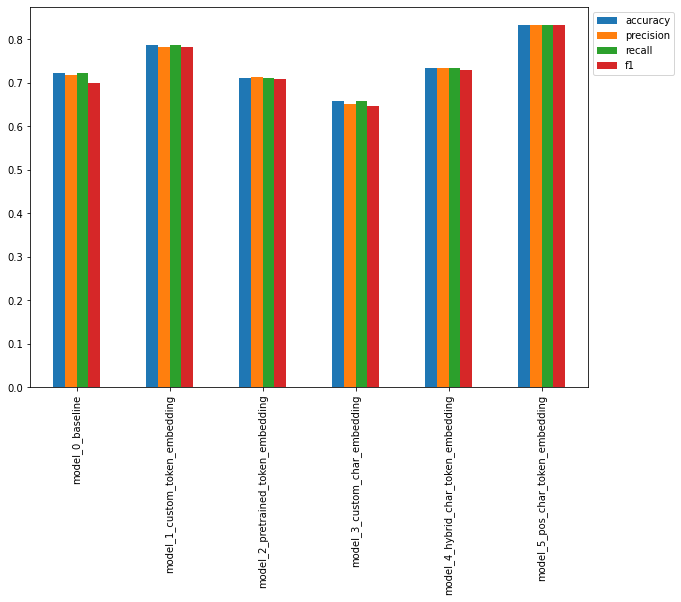

In [129]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(
    bbox_to_anchor=(1.0, 1.0)
)

<AxesSubplot:>

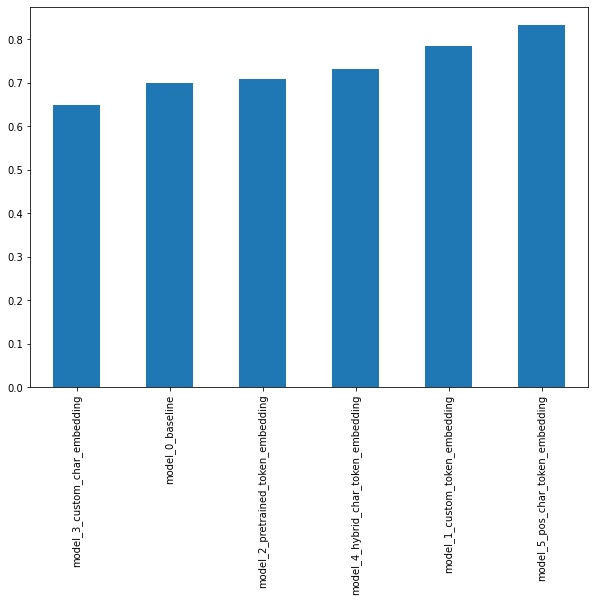

In [130]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(
    kind='bar', figsize=(10, 7))